#### Importing necessary libraries
- Pandas is the library used for the data manipulation and analysis
- Numpy is the library that provides a range of tools and functions that make it easy to perform mathematical operations
- Seaborn is a data visualisation library. It is built on top of the Matplotlib library.
- Matplotlib is a data visualisation library. It is used as the foundation for many other higher-level plotting libraries, such as Seaborn.

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Reading the csv file
The CSV file is read and placed in a dataframe named **df**.

In [56]:
df = pd.read_csv("/Users/anna-alexandradanchenko/Documents/University/PF/ICA2/resources/covid-data.csv")

#### Renaming the columns

The columns have been renamed to improve readability. As we are only using a limited number of columns from the dataset, we have only renamed one of the columns. The new name of the column is more descriptive and intuitive than the original name.

In [57]:
df.rename({"location": "country"}, axis=1, inplace=True)

#### Creating new columns
The "Month" column will help with grouping data and building more readable and optimized graphs. 

In [58]:
df['Month'] = pd.to_datetime(df['date']).dt.to_period('M')

#### Handling missing data
The rows where the value in the "continent" column is missing should be removed. In the dataset used, if the continent is missing, the corresponding country does not exist (e.g. "World" or "Asia", etc).

In [59]:
df = df.dropna(axis=0, subset=['continent'])

In column "iso_code", rows that begin with "OWID" can be removed. These rows do not correspond to valid countries as they do not have a valid iso_code. Examples include "Wales", "Scotland", etc.

In [60]:
df = df[~df["iso_code"].astype(str).str.startswith('OWID')]

For some small islands in Oceania we don't have any data. We also don't have any data for such countries as Turkmenistan, North Korea, etc. Let's delete them. It can be done using For Loop. 

In [61]:
locations_todrop = ["Turkmenistan", "Tuvalu", "North Korea", "Niue", "Nauru", "Tonga", "Anguilla", "Jersey", 
                    "Guam", "Guernsey", "United States Virgin Islands", "Sint Maarten (Dutch part)", "Northern Mariana Islands",
                    "Pitcairn"]
for location in locations_todrop:
    df = df[~df["country"].astype(str).str.startswith(location)]

#### Optimizing dataset by leaving only necessary columns
We define a variable to store the columns that we need, and then use this variable to retain only those columns in the dataframe. This allows us to exclude any unnecessary columns from the dataframe. 

I've chosen this columns because they represent the data we need to analyse pandemic, such as number of new cases, number of new deaths, the date, location. 

In [62]:
to_leave = ["country", "new_cases", "new_deaths", "date", "Month", "continent"]
df = df[to_leave]  # Leaving only selected columns.

#### Checking the percentage of missing data in the columns
To calculate the percentage of missing data in the "new cases" and "new deaths" columns, the following steps should be performed:

- Determine the number of NaNs in each column
- Determine the total number of rows in the dataset
- Calculate the percentage of missing values in each column using the formula: **(number of NaNs / number of rows) * 100**

Let's put the code in function **nans_percent_check**, as we are going to use it in the future. 

In [63]:
def nans_percent_check():
    nans_cases = df['new_cases'].isnull().sum()
    nans_deaths = df['new_deaths'].isnull().sum()

    rows_number = len(df.index)

    nans_percent_cases = nans_cases / rows_number * 100
    nans_percent_deaths = nans_deaths / rows_number * 100
    
    return(print(nans_percent_cases, nans_percent_deaths))
nans_percent_check()

1.077730090605627 9.72484501669051


In the "new_cases" column, the percentage of missing values (NaNs) is below 2%, which falls within an acceptable margin of error. However, the "new_deaths" column has a higher percentage of NaNs at 10%, which is too high. Further investigation is needed to determine a solution for this issue.

##### Plotting
In our dataset, the deaths data is missing on the beginning of pandemic or in cases where there are no deaths. In order to check it, let's count the sum of the NaNs for each value in the column "new_cases". 

Firstly, we create the new column "nans_death" in which we store Bool value. If the value in "new_deaths" column is missing, the value in "nans_deaths" is true. If not, it is false. 



In [64]:
df["nans_deaths"] = df['new_deaths'].isnull()

Then, we are creating the new dataframe in which we store **df** with sum of "nans_deaths" grouped by new cases. We reset the index in df2 in order for it to be sequential.

In [65]:
df2 = df.groupby(["new_cases"])[["nans_deaths"]].sum()
df2 = df2.reset_index(drop=False)

Now, let's create a plot.

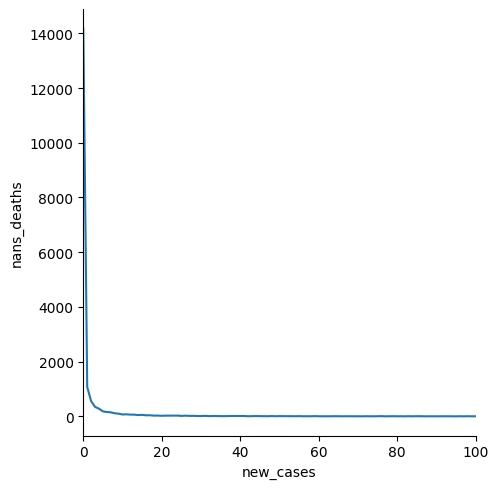

In [66]:
ax = sns.relplot(x = 'new_cases', y = 'nans_deaths', kind = 'line', data = df2)
ax.set(xlim=(0, 100))


As demonstrated by the plot, the majority of rows with missing values in the "new_deaths" column correspond to small values in the "new_cases" column. This suggests that when the number of new cases is low and no deaths are reported, there is no data available for the "new_deaths" column.

Based on this observation, we can replace the NaN values in the "new_deaths" column with a 0 if the corresponding "new_cases" value is less than 10. 

In [67]:
cases_low = df[(df["new_cases"] < 10.0)]
cases_low["new_deaths"] = cases_low["new_deaths"].replace(np.nan, 0)

df.update(cases_low)

/var/folders/6p/1jmnvrkx7jxdslfr99shm1z00000gn/T/ipykernel_34920/2206289710.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases_low["new_deaths"] = cases_low["new_deaths"].replace(np.nan, 0)
/var/folders/6p/1jmnvrkx7jxdslfr99shm1z00000gn/T/ipykernel_34920/2206289710.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.update(cases_low)


Let's check the percent of missing data in "new_cases" and "new_deaths" columns after completing the above steps. 

In [68]:
nans_percent_check()

1.077730090605627 1.559847401049118


Now, the margin of error in "new_deaths" column is 1.77, which is a satisfactory value. We can ignore it. 

Let's remove "nans_deaths" column. We don't need it anymore

In [69]:
df = df.drop("nans_deaths", axis = 1)

#### Converting columns to suitable type

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df["country"] = df["country"].astype(str)
df["continent"] = df["continent"].astype(str)

df['Month'] = df['Month'].astype(str)
df['Month'] = pd.to_datetime(df['Month'])

In order to examine the datatypes of the columns in the dataframe, we output the information from the dataframe using .info() method. The resulting dtypes of the "country" and "continent" columns are still "object". This is because the dtype of string, dict, and list is always "object" in Python.

In [155]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6268 entries, 0 to 6267
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   continent   6268 non-null   object        
 1   date        6268 non-null   datetime64[ns]
 2   new_cases   6268 non-null   float64       
 3   new_deaths  6268 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 196.0+ KB
None


Now, let's get the 10 random rows to have more global perspective

In [156]:
print(df.sample(10)) 

          continent       date  new_cases  new_deaths
3917  North America 2022-03-12    31148.0       799.0
141          Africa 2020-06-27    12237.0       202.0
3004         Europe 2022-08-05   217490.0      1101.0
5248  South America 2020-02-09        0.0         0.0
66           Africa 2020-04-13      772.0        45.0
5696  South America 2021-05-02    82500.0      2921.0
636          Africa 2021-11-04     5001.0       195.0
2473         Europe 2021-02-20   134167.0      2994.0
5020        Oceania 2022-05-20    53626.0        49.0
4364        Oceania 2020-08-02      444.0        13.0


#### Exporting cleaned data
Exporting tidy dataset into a new file.

In [157]:
df.to_csv("data-cleaned.csv")